In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Pytorch手写数字识别

参考资料：
> https://haokan.baidu.com/v?pd=wisenatural&vid=6184145319063040834
https://www.bilibili.com/video/BV1j64y1D748?p=7

一些辅助函数

In [2]:
#utils
import  torch
from    matplotlib import pyplot as plt


def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()



def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()


def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out

1. ### 导入相关包

In [3]:
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision #视觉工具包

2. ### 下载数据集

In [4]:
batch_size=512 #定义一个batch的大小

train_loader=torch.utils.data.DataLoader(#训练数据集
    torchvision.datasets.MNIST('mnist_data',train=True,download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),#转换成tensor
                                  torchvision.transforms.Normalize((0.1307,),(0.3081,))#正则化使其在0附近均匀分布
                              ])),
    batch_size=batch_size,shuffle=True#加载时随机打散
)
test_loader=torch.utils.data.DataLoader(#测试数据集
    torchvision.datasets.MNIST('mnist_data/',train=False,download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),#转换成tensor
                                  torchvision.transforms.Normalize((0.1307,),(0.3081,))#正则化使其在0附近均匀分布
                              ])),
    batch_size=batch_size,shuffle=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


看一看处理完的数据集

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


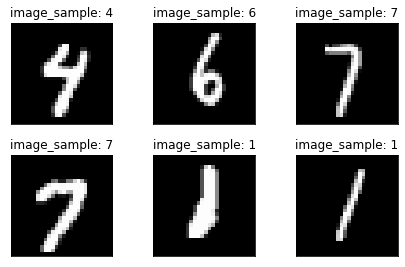

In [5]:
x,y=next(iter(train_loader))
print(x.shape,y.shape,x.min(),x.max())
plot_image(x,y,'image_sample')

3. ### 创建网络 

nn.Linear()用法：<br />
用于设置全连接层，输入与输出一般都设置为二维张量，形状通常为`[batch_size, size]`<br />
第一个参数：输入的二维张量大小`[batch_size, size]`中的size<br />
第二个参数：输出的二维张量的大小输出的二维张量的形状为`[batch_size，output_size]`<br />
> 参考https://blog.csdn.net/qq_42079689/article/details/102873766

In [6]:
class Net(nn.Module):#定义我们的网络，继承pytorch的nn
    def __init__(self):
        super(Net,self).__init__()#初始化
        
        #第一层
        self.fc1=nn.Linear(28*28,256)
        #第二层
        self.fc2=nn.Linear(256,64)#64是经验决定的
        #第三层
        self.fc3=nn.Linear(64,10)
        
    def forward(self,x):
        #x:[b,1,28,28]
        #h1=relu(xw+b)
        x=F.relu(self.fc1(x))
        #h2=relu(h1w+b)
        x=F.relu(self.fc2(x))
        #h3=h2w3+b3
        x=self.fc3(x)
        
        return x

注意：init的前后是两个下划线

4. ### 训练过程

0 0 0.10040441900491714
0 10 0.0921640396118164
0 20 0.08566787838935852
0 30 0.07834387570619583
0 40 0.07235356420278549
0 50 0.06840420514345169
0 60 0.06538622826337814
0 70 0.062026284635066986
0 80 0.058046139776706696
0 90 0.05624013394117355
0 100 0.05337189882993698
0 110 0.05373029038310051
1 0 0.04966745525598526
1 10 0.04940873757004738
1 20 0.04855190962553024
1 30 0.04575536400079727
1 40 0.0451594702899456
1 50 0.04637223854660988
1 60 0.04346683621406555
1 70 0.044371310621500015
1 80 0.04096296429634094
1 90 0.04141973704099655
1 100 0.041686948388814926
1 110 0.04037974402308464
2 0 0.04146377742290497
2 10 0.03679373115301132
2 20 0.04082031175494194
2 30 0.03721030801534653
2 40 0.03801581263542175
2 50 0.03513481467962265
2 60 0.03735331445932388
2 70 0.0340920090675354
2 80 0.033069103956222534
2 90 0.03495553508400917
2 100 0.03230679780244827
2 110 0.034303899854421616


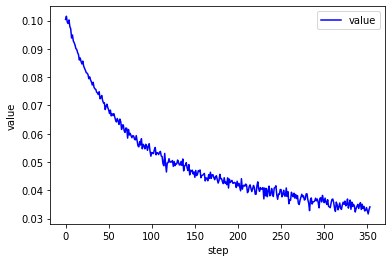

In [7]:
net=Net() #创建网络对象
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9)#优化器
train_loss=[]

for epoch in range(3):#三个epoch
    for batch_idx,(x,y) in enumerate(train_loader):
        # x: [b, 1, 28, 28], y: [512]
        # [b, 1, 28, 28] => [b, 784]由于x是四维的，得先把x打平
        x=x.view(x.size(0),28*28)
        out=net(x)
        y_onehot=one_hot(y)#将y转换成onehot
        
        #定义loss,使用梯度下降法进行优化
        loss=F.mse_loss(out,y_onehot)
        optimizer.zero_grad()#梯度清零
        loss.backward()
        #w'=w-lr.grad
        optimizer.step()
        train_loss.append(loss.item())
        
        if batch_idx%10==0:#每隔10个batch打印loss，看看是否变得更好
            print(epoch, batch_idx, loss.item())
            
plot_curve(train_loss)

loss整体在逐渐变小！

5. ### 准确度测试

test acc: 0.8869


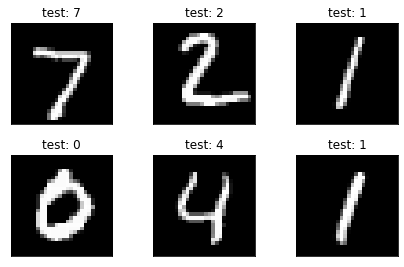

In [8]:
total_correct=0
for x,y in test_loader:
    x=x.view(x.size(0),28*28)
    out=net(x)#调用测试数据得到输出
    pred=out.argmax(dim=1)
    correct=pred.eq(y).sum().float().item()#正确的个数
    total_correct+=correct
    
total_num=len(test_loader.dataset)
acc=total_correct/total_num
print('test acc:',acc)

x,y=next(iter(test_loader))
out=net(x.view(x.size(0),28*28))
pred=out.argmax(dim=1)
plot_image(x,pred,'test')